# Forecasting

## Config environemnt

In [2]:
# Import library to use operating system functions
import os

In [3]:
# Set workspace
for dirname, _, filenames in os.walk('/Users/macbookpro/Developer/GitHub/Generickle/credit-card-forecasting'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Users/macbookpro/Developer/GitHub/Generickle/credit-card-forecasting/.DS_Store
/Users/macbookpro/Developer/GitHub/Generickle/credit-card-forecasting/LICENSE
/Users/macbookpro/Developer/GitHub/Generickle/credit-card-forecasting/CreditCardPurchaseHistoryForecasting.ipynb
/Users/macbookpro/Developer/GitHub/Generickle/credit-card-forecasting/UCI_Credit_Card.csv
/Users/macbookpro/Developer/GitHub/Generickle/credit-card-forecasting/README.md
/Users/macbookpro/Developer/GitHub/Generickle/credit-card-forecasting/PJME_hourly.csv
/Users/macbookpro/Developer/GitHub/Generickle/credit-card-forecasting/.gitignore
/Users/macbookpro/Developer/GitHub/Generickle/credit-card-forecasting/CreditCardBalanceForecasting.ipynb
/Users/macbookpro/Developer/GitHub/Generickle/credit-card-forecasting/.git/.DS_Store
/Users/macbookpro/Developer/GitHub/Generickle/credit-card-forecasting/.git/config
/Users/macbookpro/Developer/GitHub/Generickle/credit-card-forecasting/.git/HEAD
/Users/macbookpro/Developer/GitHub/Gener

## Load data

In [4]:
# Import library to manage files
import pandas as pd

In [13]:
# Load dataset
pjme_hourly_data = pd.read_csv('PJME_hourly.csv', index_col=[0], parse_dates=[0])

pjme_hourly_data.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


## EDA

In [14]:
# Stats summary
print(pjme_hourly_data.describe())

             PJME_MW
count  145366.000000
mean    32080.222831
std      6464.012166
min     14544.000000
25%     27573.000000
50%     31421.000000
75%     35650.000000
max     62009.000000


In [15]:
# Verify null data
pjme_hourly_data.isnull().sum()

PJME_MW    0
dtype: int64

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

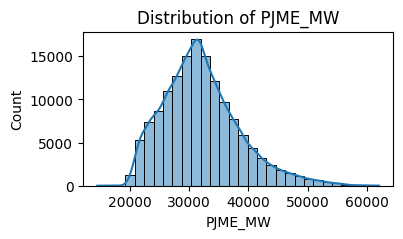

In [17]:
# Histograms for numeric variables
pjme_hourly_data_columns = pjme_hourly_data.select_dtypes(include = ['float64', 'int64']).columns

for col in pjme_hourly_data_columns:
    plt.figure(figsize = (4, 2))
    sns.histplot(pjme_hourly_data[col], kde = True, bins = 30)
    plt.title(f"Distribution of {col}")
    plt.show()


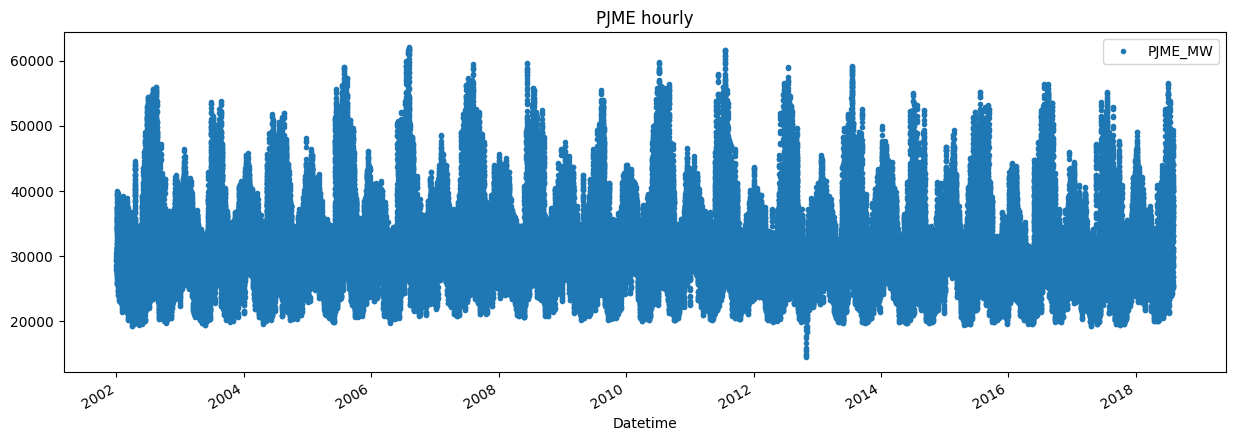

In [18]:
_ = pjme_hourly_data.plot(style = '.', figsize = (15,5), title = 'PJME hourly')

## Split data

In [90]:
split_date = '01-Jan-2015'

pjme_hourly_data_train = pjme_hourly_data.loc[pjme_hourly_data.index <= split_date].copy()
pjme_hourly_data_test = pjme_hourly_data.loc[pjme_hourly_data.index > split_date].copy()

print(pjme_hourly_data_train)
print(pjme_hourly_data_test)

                     PJME_MW
Datetime                    
2002-12-31 01:00:00  26498.0
2002-12-31 02:00:00  25147.0
2002-12-31 03:00:00  24574.0
2002-12-31 04:00:00  24393.0
2002-12-31 05:00:00  24860.0
...                      ...
2014-01-01 20:00:00  36193.0
2014-01-01 21:00:00  35601.0
2014-01-01 22:00:00  34242.0
2014-01-01 23:00:00  32215.0
2014-01-02 00:00:00  30159.0

[113927 rows x 1 columns]
                     PJME_MW
Datetime                    
2015-12-31 01:00:00  24305.0
2015-12-31 02:00:00  23156.0
2015-12-31 03:00:00  22514.0
2015-12-31 04:00:00  22330.0
2015-12-31 05:00:00  22773.0
...                      ...
2018-01-01 20:00:00  44284.0
2018-01-01 21:00:00  43751.0
2018-01-01 22:00:00  42402.0
2018-01-01 23:00:00  40164.0
2018-01-02 00:00:00  38608.0

[31439 rows x 1 columns]


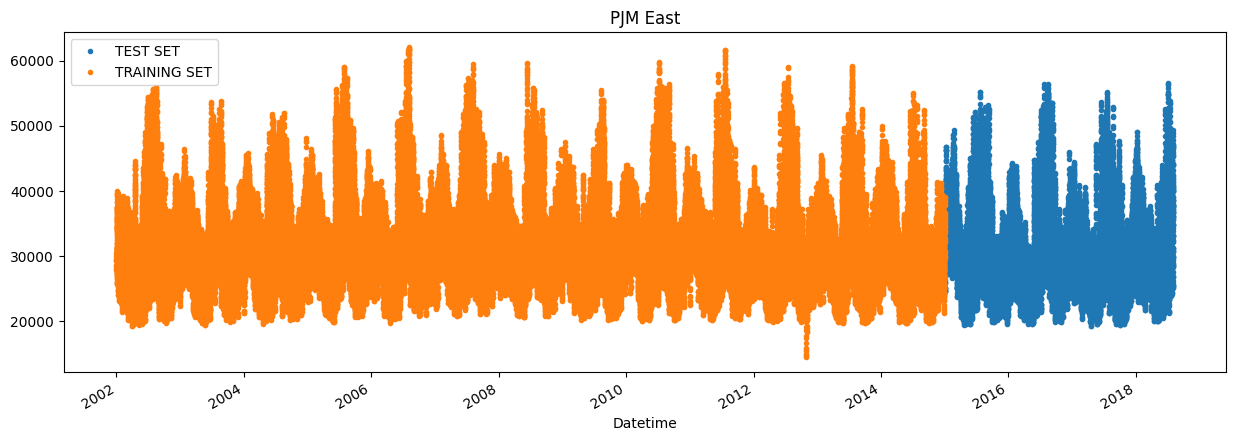

In [22]:
_ = pjme_hourly_data_test \
    .rename(columns = {'PJME_MW': 'TEST SET'}) \
    .join(pjme_hourly_data_train.rename(columns = { 'PJME_MW': 'TRAINING SET' }), how = 'outer') \
    .plot(figsize = (15, 5), title = 'PJM East', style = '.')

## Prepare data for Forcasting

In [23]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    X = df[['hour','dayofweek','quarter','month','year', 'dayofyear','dayofmonth','weekofyear']]

    if label:
        y = df[label]

        return X, y
    
    return X

In [31]:
pjme_hourly_X_train, pjme_hourly_y_train = create_features(pjme_hourly_data_train, label='PJME_MW')
pjme_hourly_X_test, pjme_hourly_y_test = create_features(pjme_hourly_data_test, label='PJME_MW')

In [32]:
pjme_hourly_X_train.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1


In [33]:
pjme_hourly_X_test.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,
2015-12-31 01:00:00,1,3,4,12,2015,365,31,53
2015-12-31 02:00:00,2,3,4,12,2015,365,31,53
2015-12-31 03:00:00,3,3,4,12,2015,365,31,53
2015-12-31 04:00:00,4,3,4,12,2015,365,31,53
2015-12-31 05:00:00,5,3,4,12,2015,365,31,53


In [34]:
pjme_hourly_y_train.head()

Datetime
2002-12-31 01:00:00    26498.0
2002-12-31 02:00:00    25147.0
2002-12-31 03:00:00    24574.0
2002-12-31 04:00:00    24393.0
2002-12-31 05:00:00    24860.0
Name: PJME_MW, dtype: float64

In [35]:
pjme_hourly_y_test.head()

Datetime
2015-12-31 01:00:00    24305.0
2015-12-31 02:00:00    23156.0
2015-12-31 03:00:00    22514.0
2015-12-31 04:00:00    22330.0
2015-12-31 05:00:00    22773.0
Name: PJME_MW, dtype: float64

## XGBoost model

In [69]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [40]:
pjme_hourly_xgboost_model = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds = 50)

pjme_hourly_xgboost_model.fit(
    pjme_hourly_X_train, pjme_hourly_y_train,
    eval_set = [(pjme_hourly_X_train, pjme_hourly_y_train), (pjme_hourly_X_test, pjme_hourly_y_test)],
    verbose = True
)

pjme_hourly_xgboost_model

[0]	validation_0-rmse:5178.20659	validation_1-rmse:5362.58699
[1]	validation_0-rmse:4381.36190	validation_1-rmse:4701.24012
[2]	validation_0-rmse:3875.94540	validation_1-rmse:4291.42311
[3]	validation_0-rmse:3568.61653	validation_1-rmse:4100.19117
[4]	validation_0-rmse:3386.60370	validation_1-rmse:3984.47407
[5]	validation_0-rmse:3235.37054	validation_1-rmse:3900.92655
[6]	validation_0-rmse:3139.99310	validation_1-rmse:3880.43917
[7]	validation_0-rmse:3050.64640	validation_1-rmse:3810.32224
[8]	validation_0-rmse:3008.72051	validation_1-rmse:3777.52114
[9]	validation_0-rmse:2949.06175	validation_1-rmse:3756.20242
[10]	validation_0-rmse:2919.69527	validation_1-rmse:3749.04384
[11]	validation_0-rmse:2837.28993	validation_1-rmse:3772.71643
[12]	validation_0-rmse:2803.01698	validation_1-rmse:3807.39750
[13]	validation_0-rmse:2740.07411	validation_1-rmse:3841.05399
[14]	validation_0-rmse:2708.28013	validation_1-rmse:3873.14074
[15]	validation_0-rmse:2678.86325	validation_1-rmse:3922.42404
[1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [76]:
# Predict with test data
pjme_hourly_xgboost_forecast = pjme_hourly_xgboost_model.predict(pjme_hourly_X_test)

# Calculate metrics
pjme_hourly_xgboost_mae = mean_absolute_error(pjme_hourly_y_test, pjme_hourly_xgboost_forecast)
pjme_hourly_xgboost_mse = mean_squared_error(pjme_hourly_y_test, pjme_hourly_xgboost_forecast)
pjme_hourly_xgboost_mape = mean_absolute_percentage_error(pjme_hourly_y_test, pjme_hourly_xgboost_forecast)

print(f"MAE: { pjme_hourly_xgboost_mae }")
print(f"MSE: { pjme_hourly_xgboost_mse }")
print(f"MAPE: { pjme_hourly_xgboost_mape }")

MAE: 2905.541158635075
MSE: 14055329.714256588
MAPE: 0.09239324261253785


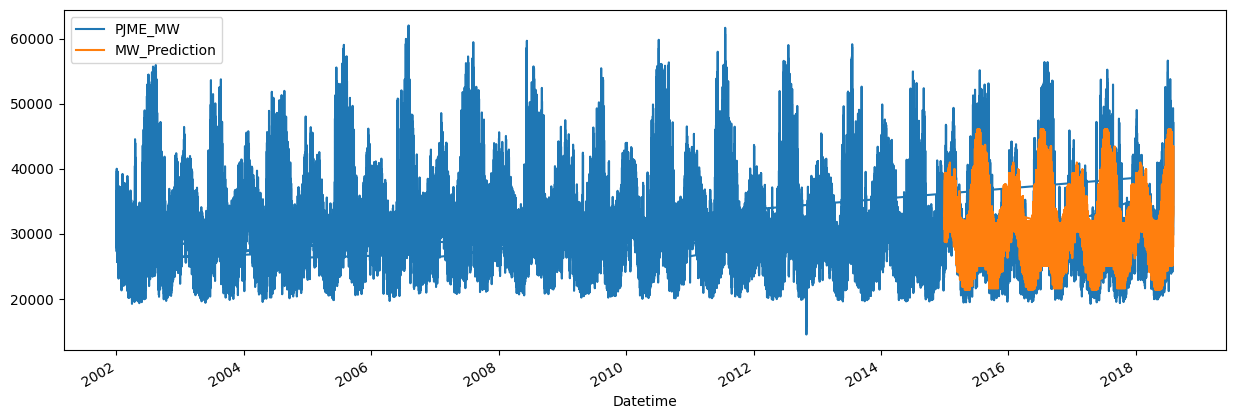

In [77]:
pjme_hourly_data_test['MW_Prediction'] = pjme_hourly_xgboost_forecast
pjme_hourly_all = pd.concat([pjme_hourly_data_test, pjme_hourly_data_train], sort=False)

_ = pjme_hourly_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

In [78]:
import pandas as pd

In [79]:
pjme_hourly_last_date = pjme_hourly_data_test.index.max()

pjme_hourly_last_date

Timestamp('2018-08-03 00:00:00')

In [80]:
# Create a future dataframe with hourly datetime index from 2018-08-03 to 2025
pjme_hourly_future_dates = pd.date_range(
    start = pjme_hourly_last_date,
    end = '2025-12-31 23:00:00',
    freq = 'H'
)

pjme_hourly_future_data = pd.DataFrame(index = pjme_hourly_future_dates)

pjme_hourly_future_data.head()

/var/folders/1l/1176zbkd1hd_ksjsrk705xxc0000gn/T/ipykernel_2794/2715259327.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pjme_hourly_future_dates = pd.date_range(


""
2018-08-03 00:00:00
2018-08-03 01:00:00
2018-08-03 02:00:00
2018-08-03 03:00:00
2018-08-03 04:00:00


In [81]:
# Generate features for the future dataframe
pjme_hourly_future_features = create_features(pjme_hourly_future_data)

# Predict the PJME_MW values for the future dataframe
pjme_hourly_future_forcasting = pjme_hourly_xgboost_model.predict(pjme_hourly_future_features)

# Add the predictions to the future dataframe
pjme_hourly_future_data['PJME_MW_Prediction'] = pjme_hourly_future_forcasting

# Display the future dataframe with predictions
pjme_hourly_future_data.head()

,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PJME_MW_Prediction
2018-08-03 00:00:00,2018-08-03 00:00:00,0,4,3,8,2018,215,3,31,33064.902344
2018-08-03 01:00:00,2018-08-03 01:00:00,1,4,3,8,2018,215,3,31,31032.207031
2018-08-03 02:00:00,2018-08-03 02:00:00,2,4,3,8,2018,215,3,31,28512.712891
2018-08-03 03:00:00,2018-08-03 03:00:00,3,4,3,8,2018,215,3,31,27971.130859
2018-08-03 04:00:00,2018-08-03 04:00:00,4,4,3,8,2018,215,3,31,27971.130859


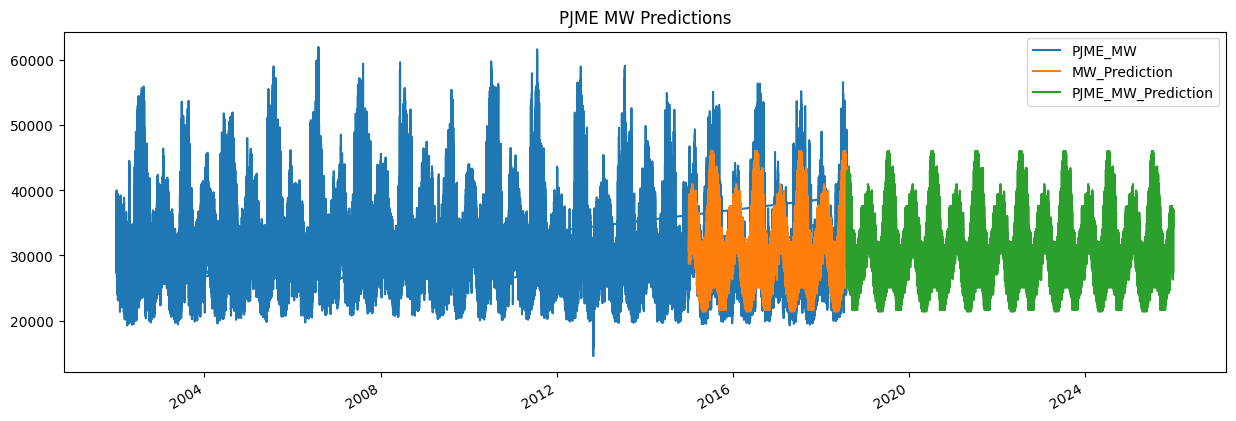

In [82]:
# Add future predictions to the combined dataframe
pjme_hourly_all = pd.concat([pjme_hourly_data_test, pjme_hourly_data_train, pjme_hourly_future_data], sort=False)

# Plot the actual and predicted values including future predictions
_ = pjme_hourly_all[['PJME_MW', 'MW_Prediction', 'PJME_MW_Prediction']]\
    .plot(figsize=(15, 5), title='PJME MW Predictions')

In [83]:
pjme_hourly_data_train

,PJME_MW,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,,
2002-12-31 01:00:00,26498.0,2002-12-31 01:00:00,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2002-12-31 02:00:00,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,2002-12-31 03:00:00,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,2002-12-31 04:00:00,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,2002-12-31 05:00:00,5,1,4,12,2002,365,31,1
...,...,...,...,...,...,...,...,...,...,...
2014-01-01 20:00:00,36193.0,2014-01-01 20:00:00,20,2,1,1,2014,1,1,1
2014-01-01 21:00:00,35601.0,2014-01-01 21:00:00,21,2,1,1,2014,1,1,1
2014-01-01 22:00:00,34242.0,2014-01-01 22:00:00,22,2,1,1,2014,1,1,1


In [84]:
pjme_hourly_future_data

,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PJME_MW_Prediction
2018-08-03 00:00:00,2018-08-03 00:00:00,0,4,3,8,2018,215,3,31,33064.902344
2018-08-03 01:00:00,2018-08-03 01:00:00,1,4,3,8,2018,215,3,31,31032.207031
2018-08-03 02:00:00,2018-08-03 02:00:00,2,4,3,8,2018,215,3,31,28512.712891
2018-08-03 03:00:00,2018-08-03 03:00:00,3,4,3,8,2018,215,3,31,27971.130859
2018-08-03 04:00:00,2018-08-03 04:00:00,4,4,3,8,2018,215,3,31,27971.130859
...,...,...,...,...,...,...,...,...,...,...
2025-12-31 19:00:00,2025-12-31 19:00:00,19,2,4,12,2025,365,31,1,37070.996094
2025-12-31 20:00:00,2025-12-31 20:00:00,20,2,4,12,2025,365,31,1,37070.996094
2025-12-31 21:00:00,2025-12-31 21:00:00,21,2,4,12,2025,365,31,1,36955.359375
2025-12-31 22:00:00,2025-12-31 22:00:00,22,2,4,12,2025,365,31,1,36389.652344


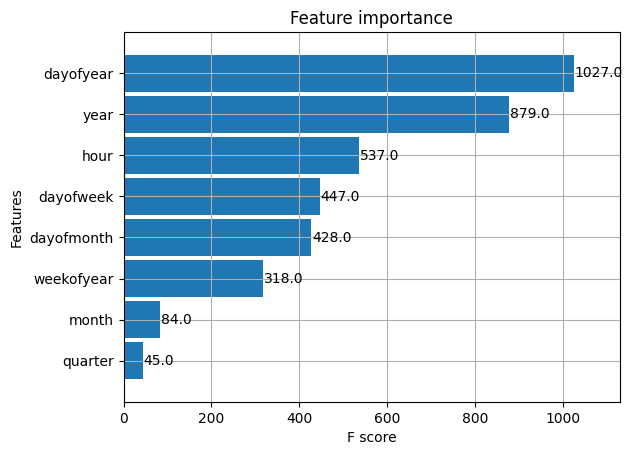

In [85]:
_ = plot_importance(pjme_hourly_xgboost_model, height=0.9)

## ARIMA model

In [72]:
import numpy as np
import statsmodels.api as sm

In [91]:
# Train ARIMA model (p, d, q)
pjme_hourly_arima_model = sm.tsa.ARIMA(pjme_hourly_y_train, order = (1, 1, 1))

# Explainme the order
# p: number of lag observations included in the model
# d: number of times that the raw observations are differenced
# q: size of the moving average window

# What other parameters can be used?
# trend: 'n', 'c', 't', 'ct'
# enforce_stationarity: True, False
# enforce_invertibility: True, False

# Train ARIMA model with other parameters
#uci_cc_arima_model = sm.tsa.ARIMA(uci_cc_y_train, order = (1,1,1), trend = 'c', enforce_stationarity = False, enforce_invertibility = False)

pjme_hourly_arima_model_fit = pjme_hourly_arima_model.fit()

# Predict on test set
pjme_hourly_arima_forecast = pjme_hourly_arima_model_fit.forecast(steps = len(pjme_hourly_y_test))

# Evaluate performance
pjme_hourly_arima_mae = mean_absolute_error(pjme_hourly_y_test, pjme_hourly_arima_forecast)
pjme_hourly_arima_mse = mean_squared_error(pjme_hourly_y_test, pjme_hourly_arima_forecast)
pjme_hourly_arima_mape = mean_absolute_percentage_error(pjme_hourly_y_test, pjme_hourly_arima_forecast)

print(f"ARIMA Model Metrics:")
print(f"MAE: {pjme_hourly_arima_mae}")
print(f"MSE: {pjme_hourly_arima_mse}")
print(f"MAPE: {pjme_hourly_arima_mape}")

/Users/macbookpro/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/macbookpro/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/macbookpro/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/macbookpro/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. for

ARIMA Model Metrics:
MAE: 6452.5217207477035
MSE: 71864320.83255433
MAPE: 0.1849775063545476


In [92]:
pjme_hourly_arima_forecast

113927    28726.610046
113928    27767.234421
113929    27124.670859
113930    26694.299355
113931    26406.048289
              ...     
145361    25821.412625
145362    25821.412625
145363    25821.412625
145364    25821.412625
145365    25821.412625
Name: predicted_mean, Length: 31439, dtype: float64

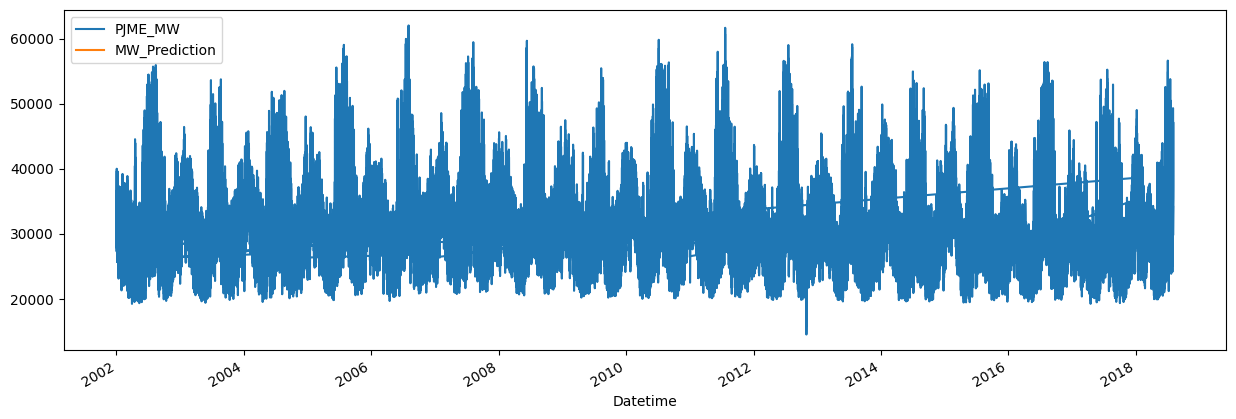

In [93]:
pjme_hourly_data_test['MW_Prediction'] = pjme_hourly_arima_forecast
pjme_hourly_all = pd.concat([pjme_hourly_data_test, pjme_hourly_data_train], sort=False)

_ = pjme_hourly_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

In [94]:
pjme_hourly_arima_future_forecast = pjme_hourly_arima_model_fit.forecast(steps = len(pjme_hourly_future_data))

pjme_hourly_arima_future_forecast

/Users/macbookpro/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/macbookpro/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


113927    28726.610046
113928    27767.234421
113929    27124.670859
113930    26694.299355
113931    26406.048289
              ...     
178914    25821.412625
178915    25821.412625
178916    25821.412625
178917    25821.412625
178918    25821.412625
Name: predicted_mean, Length: 64992, dtype: float64

In [97]:
pjme_hourly_future_data["PJME_MW_Prediction"]

2018-08-03 00:00:00    33064.902344
2018-08-03 01:00:00    31032.207031
2018-08-03 02:00:00    28512.712891
2018-08-03 03:00:00    27971.130859
2018-08-03 04:00:00    27971.130859
                           ...     
2025-12-31 19:00:00    37070.996094
2025-12-31 20:00:00    37070.996094
2025-12-31 21:00:00    36955.359375
2025-12-31 22:00:00    36389.652344
2025-12-31 23:00:00    34299.210938
Freq: h, Name: PJME_MW_Prediction, Length: 64992, dtype: float32

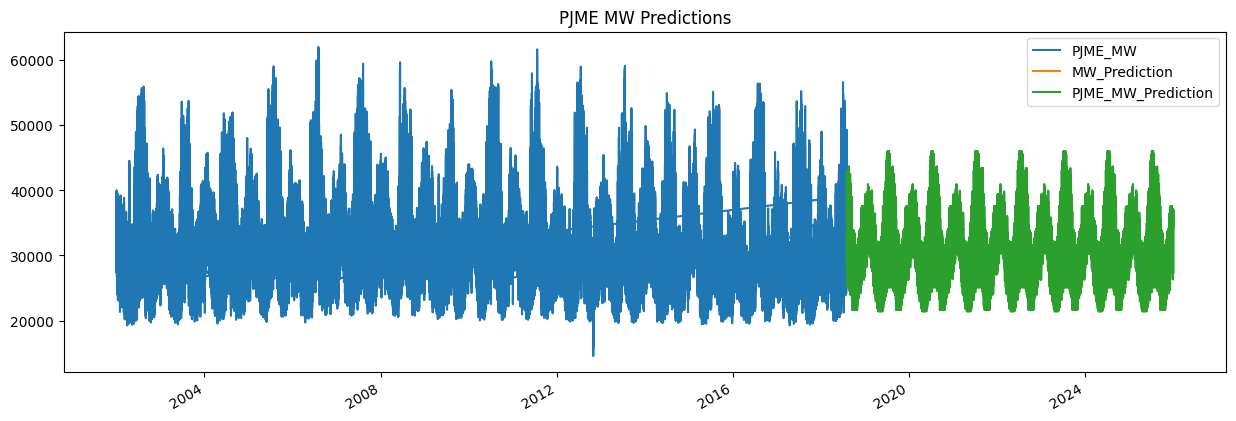

In [99]:
# Add future predictions to the combined dataframe
pjme_hourly_all = pd.concat([pjme_hourly_data_test, pjme_hourly_data_train, pjme_hourly_future_data], sort=False)

# Plot the actual and predicted values including future predictions
_ = pjme_hourly_all[['PJME_MW', 'MW_Prediction', 'PJME_MW_Prediction']]\
    .plot(figsize=(15, 5), title='PJME MW Predictions')

## SARIMA model

In [221]:
uci_cc_sarima_model = sm.tsa.SARIMAX(uci_cc_y_train, order=(1,1,1))
uci_cc_sarima_model_fit = uci_cc_sarima_model.fit()

# Predict with SARIMA
uci_cc_sarima_forecast = uci_cc_sarima_model_fit.forecast(steps=len(uci_cc_y_test))

# Evaluate performance
uci_cc_mae = mean_absolute_error(uci_cc_y_test, uci_cc_sarima_forecast)
uci_cc_mse = mean_squared_error(uci_cc_y_test, uci_cc_sarima_forecast)
uci_cc_mape = mean_absolute_percentage_error(uci_cc_y_test, uci_cc_sarima_forecast)

print(f"ARIMA Model Metrics:")
print(f"MAE: {uci_cc_mae}")
print(f"MSE: {uci_cc_mse}")
print(f"MAPE: {uci_cc_mape}")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.81772D+00    |proj g|=  5.15031D-01

At iterate    5    f=  6.56454D+00    |proj g|=  5.80981D-03

At iterate   10    f=  6.56440D+00    |proj g|=  3.92138D-04

At iterate   15    f=  6.56429D+00    |proj g|=  7.50283D-03

At iterate   20    f=  6.48394D+00    |proj g|=  1.75095D-03

At iterate   25    f=  6.48394D+00    |proj g|=  7.77438D-04

At iterate   30    f=  6.48391D+00    |proj g|=  2.86296D-03
ARIMA Model Metrics:
MAE: 1030.6268435268144
MSE: 1101891.1985242707
MAPE: 0.305457777972584

At iterate   35    f=  6.48388D+00    |proj g|=  9.24052D-04

At iterate   40    f=  6.48388D+00    |proj g|=  8.17059D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of 

/Users/macbookpro/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


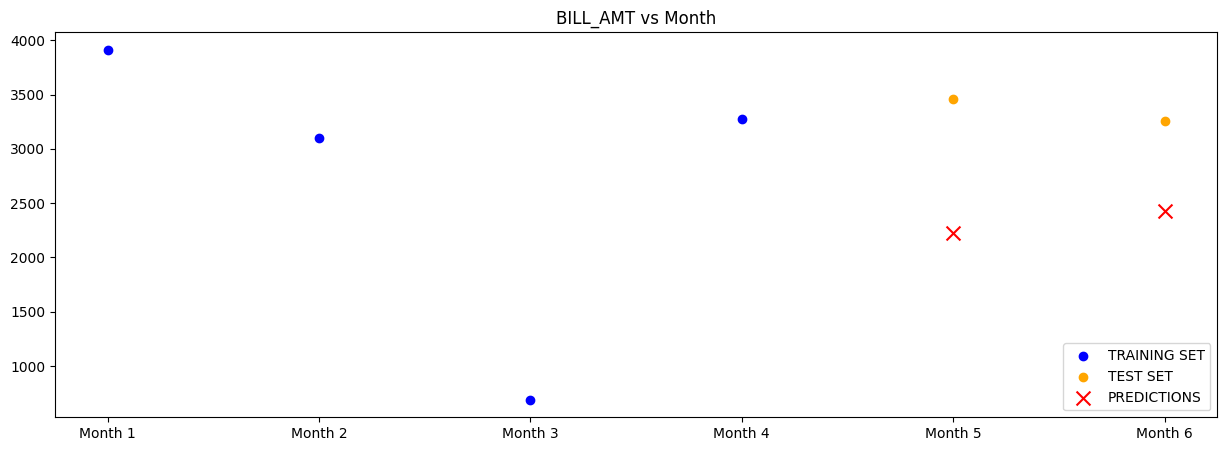

In [222]:
# Plot
plt.figure(figsize=(15, 5))

plt.scatter(
    uci_cc_data_train["Month_Num"],
    uci_cc_data_train["BILL_AMT"],
    label = "TRAINING SET",
    color = 'blue'
)

plt.scatter(
    uci_cc_data_test["Month_Num"],
    uci_cc_data_test["BILL_AMT"],
    label = "TEST SET",
    color = 'orange'
)

plt.scatter(
    uci_cc_data_test["Month_Num"],
    uci_cc_sarima_forecast,
    label = "PREDICTIONS",
    color = 'red',
    marker = 'x',
    s = 100
)

# Set x-axis labels to months
plt.xticks(list(uci_cc_month_mapping.values()), list(uci_cc_month_mapping.keys()))
plt.title("BILL_AMT vs Month")
plt.legend(loc='lower right',)
plt.show()

In [223]:
# Predict the BILL_AMT for month 7 to month 12
uci_cc_sarima_future_forecast = uci_cc_sarima_model_fit.forecast(steps = len(uci_cc_data_future))

uci_cc_sarima_future_forecast

4     2225.125803
5     2429.620510
6     2389.674846
7     2397.477767
8     2395.953557
9     2396.251294
10    2396.193134
11    2396.204495
12    2396.202276
13    2396.202709
14    2396.202625
15    2396.202641
Name: predicted_mean, dtype: float64

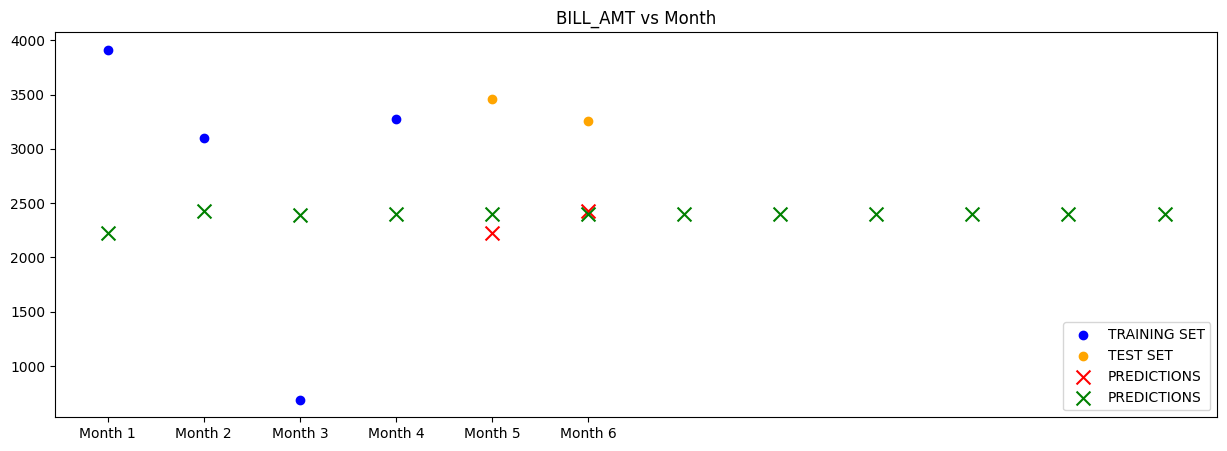

In [224]:
# Plot
plt.figure(figsize=(15, 5))

plt.scatter(
    uci_cc_data_train["Month_Num"],
    uci_cc_data_train["BILL_AMT"],
    label = "TRAINING SET",
    color = 'blue'
)

plt.scatter(
    uci_cc_data_test["Month_Num"],
    uci_cc_data_test["BILL_AMT"],
    label="TEST SET",
    color='orange'
)

plt.scatter(
    uci_cc_data_test["Month_Num"],
    uci_cc_sarima_forecast,
    label = "PREDICTIONS",
    color = 'red',
    marker = 'x',
    s = 100
)

plt.scatter(
    uci_cc_data_future["Month_Num"],
    uci_cc_sarima_future_forecast,
    label = "PREDICTIONS",
    color = 'green',
    marker = 'x',
    s = 100
)

# Set x-axis labels to months
plt.xticks(list(uci_cc_month_mapping.values()), list(uci_cc_month_mapping.keys()))
plt.title("BILL_AMT vs Month")
plt.legend(loc = 'lower right',)
plt.show()